# Emotion Detection

IMPORTING REQUIRED MODULES

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.12.0


EXPLORING DATASET

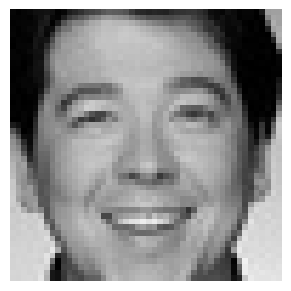

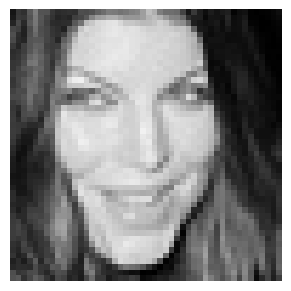

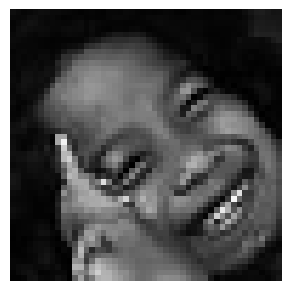

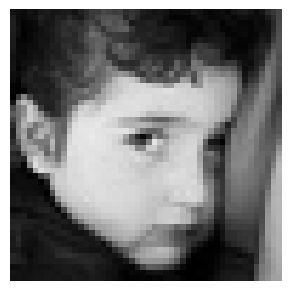

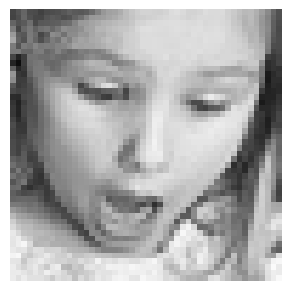

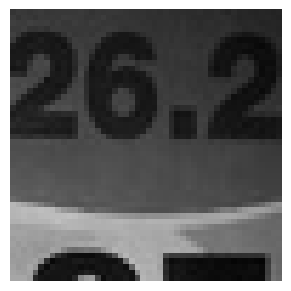

In [4]:
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(6):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

PREPARING DATA FOR TRAINING

In [6]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory("/kaggle/input/fer2013/test/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


DEFINING MODEL

In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [8]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [12]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 512, (3,3))
    conv_4 = Convolution(conv_3, 512, (3,3))
    
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)
    
    output = Dense(7,activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(lr=0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])
    
    return model

In [13]:
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0   

INITIALIZING THE MODEL

In [15]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy", save_weights_only = True, mode = "max", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]

TRAINING THE MODEL

In [16]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


2023-08-12 11:25:16.440346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.7155 - accuracy: 0.3415
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 258s 533ms/step - loss: 1.7155 - accuracy: 0.3415 - val_loss: 1.7687 - val_accuracy: 0.3225 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.4758
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 53s 119ms/step - loss: 1.3670 - accuracy: 0.4758 - val_loss: 1.4113 - val_accuracy: 0.4441 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2512 - accuracy: 0.5186
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 53s 118ms/step - loss: 1.2512 - accuracy: 0.5186 - val_loss: 1.2128 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1881 - accuracy: 0.5461
Epoch 4: saving model to model_weights.h5
448/448 [========

MODEL EVALUATION

In [17]:
model.evaluate(validation_generator)

113/113 [==============================] - 11s 100ms/step - loss: 0.9620 - accuracy: 0.6495


[0.9619711637496948, 0.6494845151901245]

PLOTTING LOSS

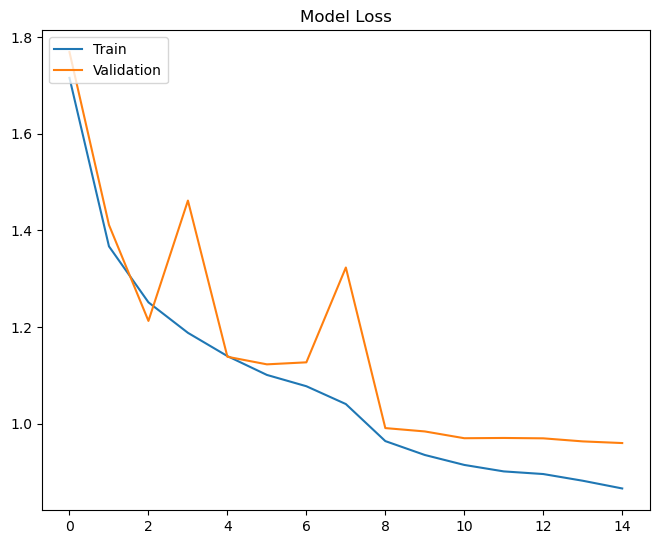

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

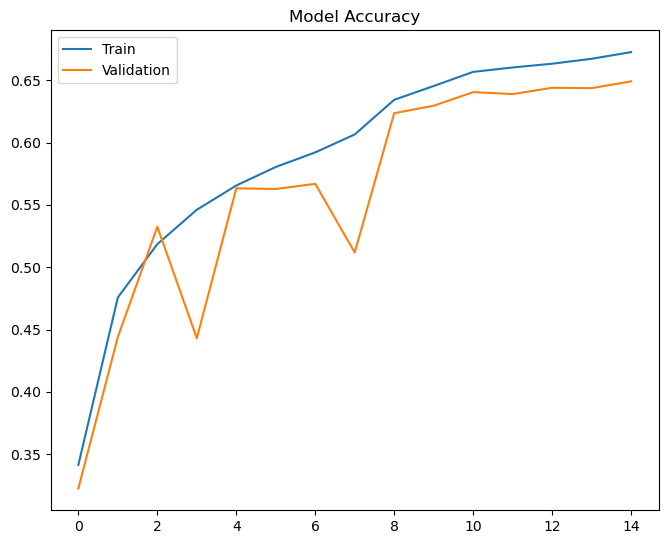

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

SAVING MODEL

In [20]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)